CELL 1 — Imports + seeds

In [1]:
# Operating system utilities
import os

# Array handling
import numpy as np

# Pickle for loading normalization stats
import pickle

# EEG preprocessing libraries
import mne
import pywt

# Machine learning utilities
from sklearn.decomposition import FastICA
from sklearn.metrics import confusion_matrix

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras

# Reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Imports loaded and seeds set.")


C:\Users\HP\anaconda3\envs\DL\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


✅ Imports loaded and seeds set.


CELL 2 — Load trained model + normalization stats

In [2]:
# ============================================================
# EEGViT – SAFE INFERENCE SCRIPT (ALL-IN-ONE)
# ============================================================

import os
import zipfile
import tempfile
import pickle
import tensorflow as tf
from tensorflow.keras import layers, Model


# ============================================================
# PATHS
# ============================================================

MODEL_PATH = r"C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Alzheimer\model inference\EEGViT model\ad_eegvit-v1.keras"
MEAN_PATH  = r"C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Alzheimer\model inference\train_mean.pkl"
STD_PATH   = r"C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Alzheimer\model inference\train_std.pkl"
SAFE_MODEL_PATH = r"C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Alzheimer\model inference\ad_eegvit-v1_SAFE.h5"


# ============================================================
# TRANSFORMER BLOCK
# ============================================================

def transformer_block(x, dim, heads, dim_head, mlp_dim, dropout):
    # --- Self-attention (PreNorm) ---
    x_norm1 = layers.LayerNormalization()(x)
    attn = layers.MultiHeadAttention(
        num_heads=heads,
        key_dim=dim_head,
        dropout=dropout,
    )(x_norm1, x_norm1)
    attn = layers.Dense(dim)(attn)
    attn = layers.Dropout(dropout)(attn)
    x = layers.Add()([x, attn])

    # --- Feed-forward (PreNorm) ---
    x_norm2 = layers.LayerNormalization()(x)
    ff = layers.Dense(mlp_dim, activation="gelu")(x_norm2)
    ff = layers.Dropout(dropout)(ff)
    ff = layers.Dense(dim)(ff)
    ff = layers.Dropout(dropout)(ff)
    x = layers.Add()([x, ff])

    return x


# ============================================================
# CLS TOKEN + POSITIONAL EMBEDDING
# ============================================================

class AddClassTokenAndPosEmbedding(layers.Layer):
    def __init__(self, num_patches, dim, emb_dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.dim = dim
        self.dropout = layers.Dropout(emb_dropout)

    def build(self, input_shape):
        self.pos_embedding = self.add_weight(
            name="pos_embedding",
            shape=(1, self.num_patches + 1, self.dim),
            initializer="random_normal",
            trainable=True,
        )
        self.cls_token = self.add_weight(
            name="cls_token",
            shape=(1, 1, self.dim),
            initializer="random_normal",
            trainable=True,
        )
        super().build(input_shape)

    def call(self, x, training=None):
        B = tf.shape(x)[0]
        cls_tokens = tf.repeat(self.cls_token, repeats=B, axis=0)
        x = tf.concat([cls_tokens, x], axis=1)
        x = x + self.pos_embedding[:, :tf.shape(x)[1], :]
        return self.dropout(x, training=training)


# ============================================================
# EEGViT MODEL (MATCHES TRAINING EXACTLY)
# ============================================================

def build_eeg_vit_keras(
    num_chan=127,
    num_time=100,
    num_patches=10,
    num_classes=1,
    dim=32,
    depth=4,
    heads=16,
    mlp_dim=64,
    dim_head=64,
    dropout=0.1,
    emb_dropout=0.1,
    pool="cls",
):

    assert num_time % num_patches == 0
    patch_len = num_time // num_patches

    inp = layers.Input(shape=(num_chan, num_time), name="eeg_input")

    # ---- Patch embedding ----
    def to_patches(t):
        B = tf.shape(t)[0]
        C = tf.shape(t)[1]
        t = tf.reshape(t, (B, C, num_patches, patch_len))
        t = tf.transpose(t, perm=[0, 2, 1, 3])
        t = tf.reshape(t, (B, num_patches, C * patch_len))
        return t

    x = layers.Lambda(to_patches, name="to_patches")(inp)
    x = layers.Dense(dim, name="patch_linear")(x)

    # ---- CLS + positional embedding ----
    x = AddClassTokenAndPosEmbedding(
        num_patches=num_patches,
        dim=dim,
        emb_dropout=emb_dropout,
        name="cls_pos_embedding"
    )(x)

    # ---- Transformer encoder ----
    for _ in range(depth):
        x = transformer_block(
            x,
            dim=dim,
            heads=heads,
            dim_head=dim_head,
            mlp_dim=mlp_dim,
            dropout=dropout,
        )

    # ---- Pooling ----
    if pool == "mean":
        x = tf.reduce_mean(x, axis=1)
    else:
        x = x[:, 0, :]

    x = layers.LayerNormalization(name="final_norm")(x)

    out = layers.Dense(1, activation="sigmoid", name="output")(x)
    return Model(inp, out, name="EEGViT")


# ============================================================
# EXTRACT WEIGHTS FROM .KERAS
# ============================================================

def extract_weights_from_keras(keras_path):
    tmp_dir = tempfile.mkdtemp(prefix="keras_weights_")
    with zipfile.ZipFile(keras_path, "r") as z:
        names = z.namelist()
        weight_files = [
            n for n in names
            if n.endswith(".h5") and "weights" in n.lower()
        ]
        if not weight_files:
            raise FileNotFoundError("No weights file found inside .keras")
        z.extract(weight_files[0], tmp_dir)
        return os.path.join(tmp_dir, weight_files[0])


# ============================================================
# BUILD MODEL + LOAD WEIGHTS
# ============================================================

model = build_eeg_vit_keras()

weights_path = extract_weights_from_keras(MODEL_PATH)
model.load_weights(weights_path)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.5)]
)

print("✅ EEGViT model loaded successfully.")


# ============================================================
# LOAD TRAINING MEAN / STD
# ============================================================

with open(MEAN_PATH, "rb") as f:
    train_mean = pickle.load(f)

with open(STD_PATH, "rb") as f:
    train_std = pickle.load(f)

print("✅ Training mean and std loaded.")


# ============================================================
# SAVE SAFE MODEL
# ============================================================

model.save(SAFE_MODEL_PATH)
print(f"✅ Safe EEGViT model saved to:\n{SAFE_MODEL_PATH}")


✅ EEGViT model loaded successfully.
✅ Training mean and std loaded.
✅ Safe EEGViT model saved to:
C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Alzheimer\model inference\ad_eegvit-v1_SAFE.h5


CELL 3 — Load ONLY excluded trials

In [3]:
# Local EEG data paths
NEG_PATH = r"D:\Dermerzel\SomnasNest\Alzheimer\Data\ad_negative.npy"
POS_PATH = r"D:\Dermerzel\SomnasNest\Alzheimer\Data\ad_positive.npy"

# Load full arrays
X_neg_full = np.load(NEG_PATH).astype(np.float32)
X_pos_full = np.load(POS_PATH).astype(np.float32)

print("✅ EEG arrays loaded.")
print("Negative shape:", X_neg_full.shape)
print("Positive shape:", X_pos_full.shape)

# Extract ONLY last 5 trials (excluded during training)
X_neg_excluded = X_neg_full[-5:]
X_pos_excluded = X_pos_full[-5:]

print("✅ Extracted excluded trials:")
print("Excluded negative:", X_neg_excluded.shape)
print("Excluded positive:", X_pos_excluded.shape)


✅ EEG arrays loaded.
Negative shape: (31, 127, 150000)
Positive shape: (46, 127, 150000)
✅ Extracted excluded trials:
Excluded negative: (5, 127, 150000)
Excluded positive: (5, 127, 150000)


CELL 4 — Select ONLY last ad_negative sample (target = 0)

In [37]:
# Select ONLY the last excluded positive trial
X_test_trial = X_pos_excluded[-5]        # last unseen ad_positive sample
y_test_trial = 1                         # ground truth label (positive)

print("✅ Selected last excluded ad_positive trial.")
print("Trial shape:", X_test_trial.shape)
print("Ground truth label:", y_test_trial)


✅ Selected last excluded ad_positive trial.
Trial shape: (127, 150000)
Ground truth label: 1


* downsampling

In [38]:
# --- Downsample from 1000 Hz -> 500 Hz (keep output name: X_test_trial) ---
sfreq_in = 1000
sfreq_out = 500

X_test_trial = mne.filter.resample(
    X_test_trial.astype(np.float64, copy=False),
    down=sfreq_in // sfreq_out,   # 2
    npad="auto",
    axis=-1,
    verbose=True
).astype(np.float32, copy=False)

print("✅ Downsampled X_test_trial to 500 Hz.")
print("Trial shape after downsampling:", X_test_trial.shape, X_test_trial.dtype)


ERROR! Session/line number was not unique in database. History logging moved to new session 253
✅ Downsampled X_test_trial to 500 Hz.
Trial shape after downsampling: (127, 75000) float32


CELL 5 — Helper + preprocessing classes

In [39]:
# Helper to generate channel names
def _names_from_index_mapping(n_channels, index_to_name):
    return [f"EEG{i+1}" for i in range(n_channels)]

# Helper to create MNE Raw object
def _make_raw(eeg, sfreq, ch_names):
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")
    return mne.io.RawArray(eeg, info, verbose=False)

# Wavelet ICA class
class WaveletICA:
    def __init__(self, wavelet="db4", level=3, n_components=10):
        self.wavelet = wavelet
        self.level = level
        self.n_components = n_components
        self.ica = None

    def fit(self, X):
        coeffs = pywt.wavedec(X, self.wavelet, level=self.level, axis=1)
        A = coeffs[0]
        self.ica = FastICA(n_components=min(self.n_components, X.shape[0]), random_state=42)
        S = self.ica.fit_transform(A.T)
        coeffs[0] = self.ica.inverse_transform(S).T
        pywt.waverec(coeffs, self.wavelet, axis=1)

    def transform(self, X):
        coeffs = pywt.wavedec(X, self.wavelet, level=self.level, axis=1)
        A = coeffs[0]
        S = self.ica.transform(A.T)
        coeffs[0] = self.ica.inverse_transform(S).T
        return pywt.waverec(coeffs, self.wavelet, axis=1)

print("✅ Preprocessing helpers defined.")


✅ Preprocessing helpers defined.


CELL 6 — Apply preprocessing to unseen test trial

In [40]:
# Sampling frequency (same as training)
fs = 500.0

# Create Raw object
raw = _make_raw(X_test_trial, fs, _names_from_index_mapping(X_test_trial.shape[0], None))

# Notch filtering
raw.notch_filter([50, 100, 150], verbose=False)

# High-pass filtering
raw.filter(l_freq=0.05, h_freq=None, verbose=False)

# Common average reference
raw.set_eeg_reference("average", projection=True)
raw.apply_proj()

# Extract cleaned signal
X_clean = raw.get_data().astype(np.float32)

print("✅ Preprocessing applied.")
print("Cleaned trial shape:", X_clean.shape)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
✅ Preprocessing applied.
Cleaned trial shape: (127, 75000)


CELL 7 — Segment test trial

In [41]:
# Segment size
SEGMENT_SIZE = 100

# Segment the trial
segments = []
for i in range(X_clean.shape[1] // SEGMENT_SIZE):
    seg = X_clean[:, i*SEGMENT_SIZE:(i+1)*SEGMENT_SIZE]
    segments.append(seg)

# Convert to array
X_test_segments = np.array(segments, dtype=np.float32)

print("✅ Trial segmented.")
print("Segments shape:", X_test_segments.shape)


✅ Trial segmented.
Segments shape: (750, 127, 100)


CELL 8 — Reshape + normalize using TRAINING stats

In [42]:
# Add channel dimension
X_test = X_test_segments[..., np.newaxis]

# Normalize using training mean/std
X_test_norm = (X_test - train_mean) / train_std

print("✅ Normalization applied using training statistics.")
print("Final test shape:", X_test_norm.shape)


✅ Normalization applied using training statistics.
Final test shape: (750, 127, 100, 1)


CELL 9 — Run inference

In [43]:
# Predict probabilities for each segment
y_probs = model.predict(X_test_norm, verbose=0)

# Convert probabilities to binary predictions
y_preds = (y_probs >= 0.5).astype(int).flatten()

# Ground truth labels (ALL ones because ad_positive)
y_true = np.ones_like(y_preds)

print("✅ Inference completed for ad_positive trial.")
print("First 10 predicted labels:", y_preds[:10])
print("Total segments:", len(y_preds))


✅ Inference completed for ad_positive trial.
First 10 predicted labels: [1 1 1 1 1 1 1 1 1 1]
Total segments: 750


CELL 10 — Confusion matrix plot

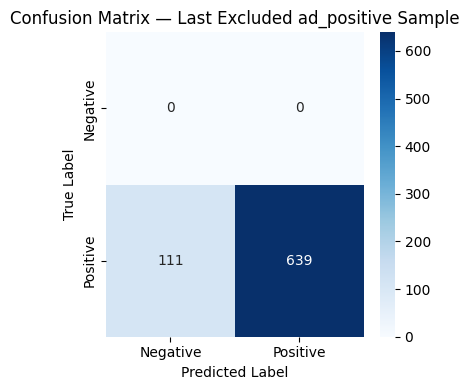

✅ Confusion matrix plotted for ad_positive trial.


In [44]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_preds)

# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Last Excluded ad_positive Sample")
plt.tight_layout()
plt.show()

print("✅ Confusion matrix plotted for ad_positive trial.")


In [45]:
# %% Step 11 - Gradient-based saliency scores (for your unseen trial segments)

import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import numpy as np

# ✅ Your electrode list (must match channel order in X_test_norm)
electrode_names = [
    'Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2',
    'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz',
    'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2',
    'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF8', 'AF4', 'F2', 'F9', 'AFF1h', 'FFC1h', 'FFC5h', 'FTT7h',
    'FCC3h', 'CCP1h', 'CCP5h', 'TPP7h', 'P9', 'PPO9h', 'PO9', 'O9', 'OI1h', 'PPO1h', 'CPP3h', 'CPP4h', 'PPO2h', 'OI2h',
    'O10', 'PO10', 'PPO10h', 'P10', 'TPP8h', 'CCP6h', 'CCP2h', 'FCC4h', 'FTT8h', 'FFC6h', 'FFC2h', 'AFF2h', 'F10',
    'AFp1', 'AFF5h', 'FFT9h', 'FFT7h', 'FFC3h', 'FCC1h', 'FCC5h', 'FTT9h', 'TTP7h', 'CCP3h', 'CPP1h', 'CPP5h', 'TPP9h',
    'POO9h', 'PPO5h', 'POO1', 'POO2', 'PPO6h', 'POO10h', 'TPP10h', 'CPP6h', 'CPP2h', 'CCP4h', 'TTP8h', 'FTT10h',
    'FCC6h', 'FCC2h', 'FFC4h', 'FFT8h', 'FFT10h', 'AFF6h', 'AFp2'
]

# --- Safety check: electrode count must match your data channel count ---
n_channels_data = X_test_norm.shape[1]
if len(electrode_names) != n_channels_data:
    print(f"⚠️ Electrode list length = {len(electrode_names)} but X_test_norm has {n_channels_data} channels.")
    # Fallback: auto-generate names to avoid crashing (or trim if electrode list is longer)
    if len(electrode_names) > n_channels_data:
        electrode_names = electrode_names[:n_channels_data]
        print(f"✅ Trimmed electrode list to {n_channels_data}.")
    else:
        electrode_names = [f"EEG{i+1}" for i in range(n_channels_data)]
        print(f"✅ Using auto-generated names EEG1..EEG{n_channels_data}.")

def compute_electrode_saliency(model, input_sample, class_index=1):
    """
    Compute per-electrode saliency for ONE sample shaped like (1, C, T, 1).
    Works for sigmoid (1 output) or softmax (>=2 outputs).
    """
    input_sample = tf.convert_to_tensor(input_sample, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(input_sample)
        pred = model(input_sample, training=False)

        # Make a scalar target to differentiate
        if pred.shape[-1] == 1:
            target = pred[:, 0]                          # sigmoid probability
        else:
            target = pred[:, class_index]                # softmax probability for class_index

    grads = tape.gradient(target, input_sample)          # same shape as input_sample
    grads = tf.abs(grads)

    # Average over time and "channel dimension" (the last dim=1) -> keep electrodes
    # input shape: (1, C, T, 1) => reduce over T and last dim
    saliency = tf.reduce_mean(grads, axis=(2, 3))        # -> (1, C)
    return saliency.numpy().flatten()

# Compute saliency for each segment in your unseen trial
all_saliencies = []
for i in tqdm(range(X_test_norm.shape[0]), desc="Computing Saliency (segments)"):
    sample = X_test_norm[i:i+1]                          # (1, C, T, 1)
    sal = compute_electrode_saliency(model, sample, class_index=1)
    all_saliencies.append(sal)

all_saliencies = np.array(all_saliencies, dtype=np.float32)   # (n_segments, C)

# Aggregate across segments
mean_saliency = np.mean(all_saliencies, axis=0)               # (C,)
normalized_saliency = mean_saliency / (np.max(mean_saliency) + 1e-8)

# Save CSV
saliency_df = pd.DataFrame({
    "Electrode": electrode_names,
    "Saliency Score": normalized_saliency
})

out_csv = "gradient_saliency_scores_last_excluded_ad_positive_trial.csv"
saliency_df.to_csv(out_csv, index=False)
print(f"✅ Saved gradient-based saliency scores to '{out_csv}'")


Computing Saliency (segments):  16%|█▋        | 122/750 [00:27<02:20,  4.47it/s]


KeyboardInterrupt: 

In [ ]:
# %% [NEW CELL] Clear topomap: BIG dots + labels with leader lines (robust for your channel set)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne

# -------- 1) Load values --------
if "normalized_saliency" in globals() and "electrode_names" in globals():
    ch_names_orig = list(electrode_names)
    values_orig = np.asarray(normalized_saliency, dtype=float)
else:
    # Change filename if needed
    df = pd.read_csv("70th_gradient_saliency_scores.csv")
    ch_names_orig = df["Electrode"].astype(str).tolist()
    values_orig = df["Saliency Score"].to_numpy(dtype=float)

# -------- 2) Build mapping to montage channel names --------
# Many high-density names end with "h" (e.g., AFF1h). Standard montages often store them without "h".
def montage_lookup_name(name: str) -> str:
    n = name.strip()
    if n.endswith("h") and len(n) > 1:
        return n[:-1]  # AFF1h -> AFF1
    return n

ch_names_lookup = [montage_lookup_name(n) for n in ch_names_orig]

# -------- 3) Create info & set a montage with custom positions --------
# Use standard_1005 for broader coverage than standard_1020
base_montage = mne.channels.make_standard_montage("standard_1005")
base_pos = base_montage.get_positions()["ch_pos"]  # dict: {name: xyz}

# Create a custom position dict for *your original* channel names
# by borrowing xyz from the lookup name if available.
ch_pos_custom = {}
keep_idx = []
for i, (orig, look) in enumerate(zip(ch_names_orig, ch_names_lookup)):
    if look in base_pos:
        ch_pos_custom[orig] = base_pos[look]
        keep_idx.append(i)

if len(keep_idx) == 0:
    raise RuntimeError(
        "No channels matched the montage. Try a different montage (e.g., 'biosemi160') "
        "or provide a custom electrode position file."
    )

# Keep only channels we can place
ch_names = [ch_names_orig[i] for i in keep_idx]
values = values_orig[keep_idx]

# Create info and apply custom dig montage
info = mne.create_info(ch_names=ch_names, sfreq=1000.0, ch_types="eeg")
custom_montage = mne.channels.make_dig_montage(ch_pos=ch_pos_custom, coord_frame="head")
info.set_montage(custom_montage, on_missing="ignore")

# -------- 4) Compute 2D topomap coordinates (only valid channels exist here) --------
coords2d = mne.channels.layout._find_topomap_coords(info, picks=np.arange(len(ch_names)))

# -------- 5) Plot BIG + crisp --------
fig, ax = plt.subplots(figsize=(14, 9), dpi=250)

vmin, vmax = float(values.min()), float(values.max())  # or set fixed range manually

im, cn = mne.viz.plot_topomap(
    values,
    info,
    axes=ax,
    show=False,
    contours=6,
    sensors=False,      # draw our own dots
    outlines="head",
    vlim=(vmin, vmax),
    cmap="jet",
)

# -------- 6) Draw big dots + labels with outward leader lines --------
dot_size = 18
font_size = 13
arrow_lw = 0.9

for (x, y), name in zip(coords2d, ch_names):
    # big dot
    ax.plot(x, y, "k.", markersize=dot_size, zorder=10)

    # radial outward label placement
    r = np.sqrt(x * x + y * y) + 1e-9
    ux, uy = x / r, y / r  # outward unit vector

    # base offset outward + a tiny vertical lift to reduce overlap
    offset_out = 0.085
    offset_lift = 0.015

    x_text = x + ux * offset_out
    y_text = y + uy * offset_out + (offset_lift if y >= 0 else -offset_lift)

    ax.annotate(
        name,
        xy=(x, y),
        xytext=(x_text, y_text),
        textcoords="data",
        fontsize=font_size,
        fontweight="bold",
        ha="left" if x_text >= x else "right",
        va="center",
        bbox=dict(facecolor="white", edgecolor="black", alpha=0.88, pad=0.25),
        arrowprops=dict(arrowstyle="-", color="black", lw=arrow_lw),
        zorder=11,
    )

# -------- 7) Colorbar + title --------
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Electrode importance", fontsize=14)
cbar.ax.tick_params(labelsize=12)

missing = len(ch_names_orig) - len(ch_names)
ax.set_title(
    f"Topographic map of electrode importance (clear labels)\n"
    f"Plotted {len(ch_names)} channels (skipped {missing} without montage positions)",
    fontsize=18,
)

ax.set_axis_off()
plt.tight_layout()
plt.show()


In [ ]:
# %% CELL 9B — Calculate Average Probability (Production-Style)

"""
This matches the production code calculation:
1. Get sigmoid probabilities per segment
2. Average across all segments
3. Determine class and confidence
"""

# Get raw probabilities (already computed in Cell 9)
# y_probs is shape (n_segments, 1) - sigmoid output per segment

# Calculate average probability across all segments
avg_probability = float(np.mean(y_probs))

# Determine predicted class using 0.5 threshold
predicted_class = "positive" if avg_probability >= 0.5 else "negative"

# Calculate confidence (production logic)
if avg_probability >= 0.5:
    confidence = avg_probability
else:
    confidence = 1.0 - avg_probability

# Display results
print("="*60)
print("PRODUCTION-STYLE PROBABILITY CALCULATION")
print("="*60)
print(f"Total segments analyzed: {len(y_probs)}")
print(f"Average sigmoid probability: {avg_probability:.6f}")
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.3f}")
print("="*60)

# Breakdown statistics
print("\nSegment Probability Statistics:")
print(f"  Min probability: {y_probs.min():.6f}")
print(f"  Max probability: {y_probs.max():.6f}")
print(f"  Median probability: {np.median(y_probs):.6f}")
print(f"  Std dev: {y_probs.std():.6f}")

# Distribution of predictions
num_positive_segments = (y_probs >= 0.5).sum()
num_negative_segments = (y_probs < 0.5).sum()
print(f"\nSegment-level predictions:")
print(f"  Positive segments: {num_positive_segments} ({100*num_positive_segments/len(y_probs):.1f}%)")
print(f"  Negative segments: {num_negative_segments} ({100*num_negative_segments/len(y_probs):.1f}%)")

# Expected output format (matches production)
output_json = {
    "status": predicted_class,
    "confidence": round(confidence, 3),
    "probability": round(avg_probability, 3),
    "metadata": {
        "total_segments": len(y_probs),
        "positive_segments": int(num_positive_segments),
        "negative_segments": int(num_negative_segments),
        "ground_truth": "positive" if y_test_trial == 1 else "negative"
    }
}

print("\n" + "="*60)
print("PRODUCTION OUTPUT FORMAT:")
print("="*60)
import json
print(json.dumps(output_json, indent=2))